# Predicting GitHub Repo Programming Language
By David Schneemann, Jarad Angel, Joshua Mayes, and Saroj Duwal

In [1]:
import pandas as pd
import numpy as np
import time
import re

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image


import acquire
import prepare
from helpers import nlp
import helpers.viz

# Sentiment Analysis Library
from textblob import TextBlob

#Modeling imports
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Supress Warnings
import warnings
warnings.filterwarnings("ignore")

# Acquisition and Wrangling

## About the data

We scraped ~1000 Github repositories from the list of most forked repositories to gather readme files and information from GitHub's language statitics.

## Scope

For exploration and modeling we ignored any repositories featuring a language for which we did not scrape at least 10 samples, as well as any repositories that did not feature a language at all.

## Acquiring

Data acquisition used a combination of web-scraping and GitHub's API.

## Preparing

To prepare the data for exploration and modeling we performed the following steps:
- Markdown links were removed from the corpus since the urls did not provide meaningful information
- HTML elements such as \<li>\</li> and \<strong>\</strong> were also removed for the same reason
- The text was then normalized and stripped of special characters
- Stopwords were removed
- New columns were created in the dataframe to represent the cleaned and lemmatized versions of the original

In [2]:
# Bringing in the data using acquire function
df = acquire.wrangle_data()

In [3]:
#Checking to see how many repos we have
df.shape

(1031, 3)

In [4]:
# Getting a glimpse of the data
df.head()

,repo,language,readme_contents
0,freeCodeCamp/freeCodeCamp,TypeScript,[![freeCodeCamp Social Banner](https://s3.amaz...
1,996icu/996.ICU,NaN,[996.ICU](https://996.icu/#/en_US)\n=======\n*...
2,EbookFoundation/free-programming-books,NaN,# List of Free Learning Resources In Many Lang...
3,jwasham/coding-interview-university,NaN,# Coding Interview University\n\n> I originall...
4,kamranahmedse/developer-roadmap,TypeScript,"<p align=""center"">\n <img src=""public/brand.p..."


In [5]:
# Converting readme to a string to run through the prepare functions
df['readme_contents'] =  df['readme_contents'].astype('string')

In [6]:
#Filling the null values in readme contents with an empty space
df.readme_contents = df.readme_contents.fillna('')

In [7]:
#Checking the total sums
df.isnull().sum()

repo                 0
language           114
readme_contents      0
dtype: int64

In [8]:
# Remove markdown links and html code
links = re.compile(r'(\(http.+\))')
html = re.compile(r'(<.*?>)')
df.readme_contents = df.readme_contents.replace(html, '')
df.readme_contents = df.readme_contents.replace(links, '')

In [9]:
#Checking data
df.head()

,repo,language,readme_contents
0,freeCodeCamp/freeCodeCamp,TypeScript,[![freeCodeCamp Social Banner] [![Pull Reques...
1,996icu/996.ICU,NaN,[996.ICU] ======= **Please note that there exi...
2,EbookFoundation/free-programming-books,NaN,# List of Free Learning Resources In Many Lang...
3,jwasham/coding-interview-university,NaN,# Coding Interview University > I originally ...
4,kamranahmedse/developer-roadmap,TypeScript,"roadmap.sh Community driven roadmaps, ..."


In [10]:
#Applying the cleaning function to the dataframe to normalize text
df['cleaned_readme'] = df.readme_contents.apply(nlp.sanitize, 
                                            # Reduce noise by removing these words as well as common stopwords
                                            extra_words=['&#9;', "'", 'nbsp', '1','2'])

In [11]:
#Checking the data
df.head()

,repo,language,readme_contents,cleaned_readme
0,freeCodeCamp/freeCodeCamp,TypeScript,[![freeCodeCamp Social Banner] [![Pull Reques...,freecodecamp social banner pull requests welco...
1,996icu/996.ICU,NaN,[996.ICU] ======= **Please note that there exi...,996icu please note exists official account app...
2,EbookFoundation/free-programming-books,NaN,# List of Free Learning Resources In Many Lang...,list free learning resources many languages aw...
3,jwasham/coding-interview-university,NaN,# Coding Interview University > I originally ...,coding interview university originally created...
4,kamranahmedse/developer-roadmap,TypeScript,"roadmap.sh Community driven roadmaps, ...",roadmapsh community driven roadmaps articles r...


In [12]:
# Tokenizing the readme contents from prepare.py
df['tokenized_readme'] = df['cleaned_readme'].map(lambda x: prepare.tokenize(x))

In [13]:
#Checking the data to see changes
df.head()

,repo,language,readme_contents,cleaned_readme,tokenized_readme
0,freeCodeCamp/freeCodeCamp,TypeScript,[![freeCodeCamp Social Banner] [![Pull Reques...,freecodecamp social banner pull requests welco...,freecodecamp social banner pull requests welco...
1,996icu/996.ICU,NaN,[996.ICU] ======= **Please note that there exi...,996icu please note exists official account app...,996icu please note exists official account app...
2,EbookFoundation/free-programming-books,NaN,# List of Free Learning Resources In Many Lang...,list free learning resources many languages aw...,list free learning resources many languages aw...
3,jwasham/coding-interview-university,NaN,# Coding Interview University > I originally ...,coding interview university originally created...,coding interview university originally created...
4,kamranahmedse/developer-roadmap,TypeScript,"roadmap.sh Community driven roadmaps, ...",roadmapsh community driven roadmaps articles r...,roadmapsh community driven roadmaps articles r...


In [14]:
# Lemmatizing the data using preapre.py
df['lemm_readme'] = df['tokenized_readme'].map(lambda x: prepare.lemmatize(x))

In [15]:
#checking the data
df.head()

,repo,language,readme_contents,cleaned_readme,tokenized_readme,lemm_readme
0,freeCodeCamp/freeCodeCamp,TypeScript,[![freeCodeCamp Social Banner] [![Pull Reques...,freecodecamp social banner pull requests welco...,freecodecamp social banner pull requests welco...,freecodecamp social banner pull request welcom...
1,996icu/996.ICU,NaN,[996.ICU] ======= **Please note that there exi...,996icu please note exists official account app...,996icu please note exists official account app...,996icu please note exists official account app...
2,EbookFoundation/free-programming-books,NaN,# List of Free Learning Resources In Many Lang...,list free learning resources many languages aw...,list free learning resources many languages aw...,list free learning resource many language awes...
3,jwasham/coding-interview-university,NaN,# Coding Interview University > I originally ...,coding interview university originally created...,coding interview university originally created...,coding interview university originally created...
4,kamranahmedse/developer-roadmap,TypeScript,"roadmap.sh Community driven roadmaps, ...",roadmapsh community driven roadmaps articles r...,roadmapsh community driven roadmaps articles r...,roadmapsh community driven roadmaps article re...


In [16]:
# determining remaining list of languages that show up more than 10 times
languages_kept = df.language.value_counts()[df.language.value_counts() > 10].index
languages_kept

Index(['JavaScript', 'Python', 'TypeScript', 'Go', 'Java', 'C++', 'C', 'HTML',
       'Shell', 'Rust', 'Swift', 'Ruby', 'PHP', 'Jupyter Notebook', 'C#',
       'CSS', 'Kotlin'],
      dtype='object')

In [17]:
# Removing languages not kept
df = df[df.language.isin(languages_kept)]

In [18]:
#Checking to see how many rows we have left
df.shape, df.dtypes

((857, 6),
 repo                object
 language            object
 readme_contents     string
 cleaned_readme      object
 tokenized_readme    object
 lemm_readme         object
 dtype: object)

In [19]:
#No language nulls to be filled
df.language.isnull().value_counts()

False    857
Name: language, dtype: int64

# Exploration

The most useful tool in our toolbelt for exploring the data turned out to be plotting the wordclouds.  Not only do they give us a decent estimation of word frequencies, they can look pretty stylish!

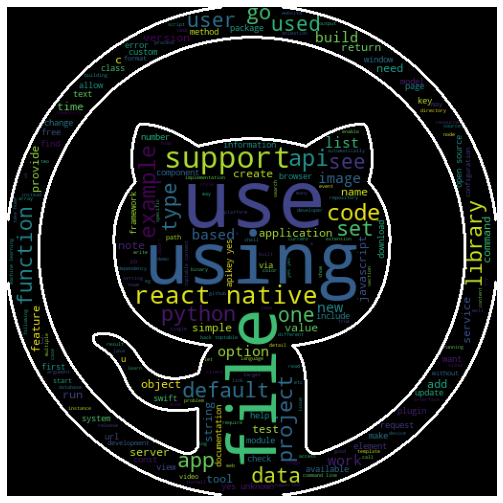

In [20]:
# Create a mask in the shape of the github logo for style points
mask = np.array(Image.open('./img/github-white.png'))
# Plot the wordcloud with the mask applied
wc = WordCloud(background_color='black', mask= mask, contour_width=2, contour_color='white')
wc.generate(' '.join(df.lemm_readme))
plt.figure(figsize=[9,9])
plt.imshow(wc)
plt.axis("off")
plt.show()

However, it can always be easier and simpler to just see them in a bar chart:

Text(0.5, 1.0, 'Top 10 words used across all READMEs')

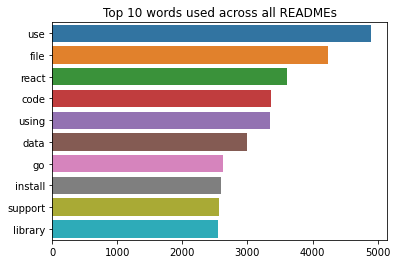

In [21]:
# Get word frequencies
vc = nlp.get_word_freq(df.lemm_readme)
# Plot
temp = vc.head(10)
sns.barplot(x= temp, y=temp.index)
plt.title('Top 10 words used across all READMEs')

## Do READMEs mention the primary language?

Using the above tools we can answer that question!

The short answer is that while this does appear to be the case for many languages

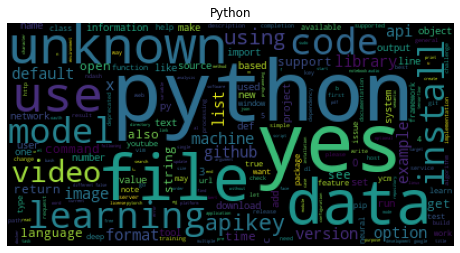

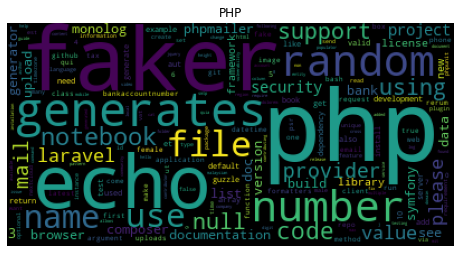

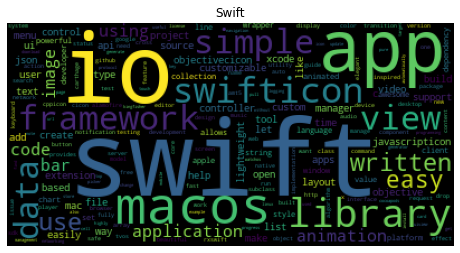

In [22]:
# Show three examples of repositories mentioning the domininant language
langs_self_mention = [  
                        'Python',
                        'PHP',
                        'Swift',
                        ]
for cat in langs_self_mention:
    helpers.viz.plot_wordcloud(df[df.language == cat].lemm_readme, title=cat, figsize=[8,6])

This pattern falls apart for others

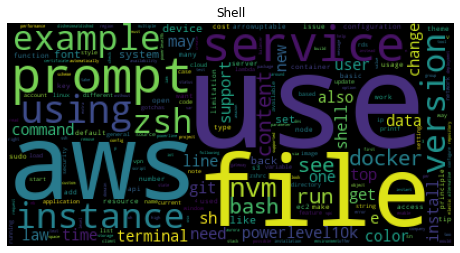

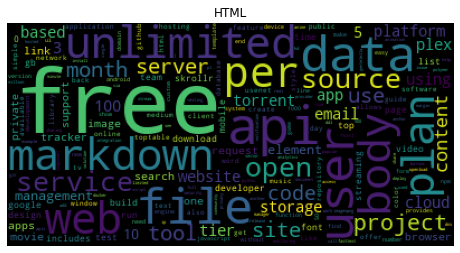

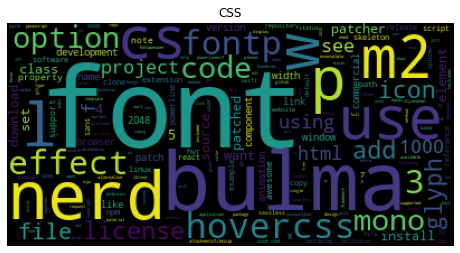

In [23]:
# Show three examples of repositories not mentioning the domininant language
langs_not_self_mention = [  
                        'Shell',
                        'HTML',
                        'CSS',
                        ]
for cat in langs_not_self_mention:
    helpers.viz.plot_wordcloud(df[df.language == cat].lemm_readme, title=cat, figsize=[8,6])

**Takeaways**:  While README files do seem to talk about topics related to the domininant language, it's not as cut and dry as "If README mentions language, the repo is primarily written in that language."

## Do Some languages score more positively on average sentiment analysis than others?

To answer that question, it's necessary to first perform sentiment analysis on each document.

In [24]:
# Performing Sentiment Analysis, iterating through each readme doc
df['polarity'] = df.lemm_readme.apply(lambda x: TextBlob (x).sentiment.polarity)
df.head()

,repo,language,readme_contents,cleaned_readme,tokenized_readme,lemm_readme,polarity
0,freeCodeCamp/freeCodeCamp,TypeScript,[![freeCodeCamp Social Banner] [![Pull Reques...,freecodecamp social banner pull requests welco...,freecodecamp social banner pull requests welco...,freecodecamp social banner pull request welcom...,0.181037
4,kamranahmedse/developer-roadmap,TypeScript,"roadmap.sh Community driven roadmaps, ...",roadmapsh community driven roadmaps articles r...,roadmapsh community driven roadmaps articles r...,roadmapsh community driven roadmaps article re...,0.107879
5,public-apis/public-apis,Python,Public APIs A collective list of free...,public apis collective list free apis use soft...,public apis collective list free apis use soft...,public apis collective list free apis use soft...,-0.027127
6,vuejs/vue,TypeScript,## This repo is for Vue...,repo vue looking repository vue repo vue 3 vue...,repo vue looking repository vue repo vue 3 vue...,repo vue looking repository vue repo vue 3 vue...,0.194270
7,facebook/react,JavaScript,# [React] React is a JavaScript library for b...,react react javascript library building user i...,react react javascript library building user i...,react react javascript library building user i...,0.201707


We can throw the new polarity score into a bar chart and quickly compare languages against each other

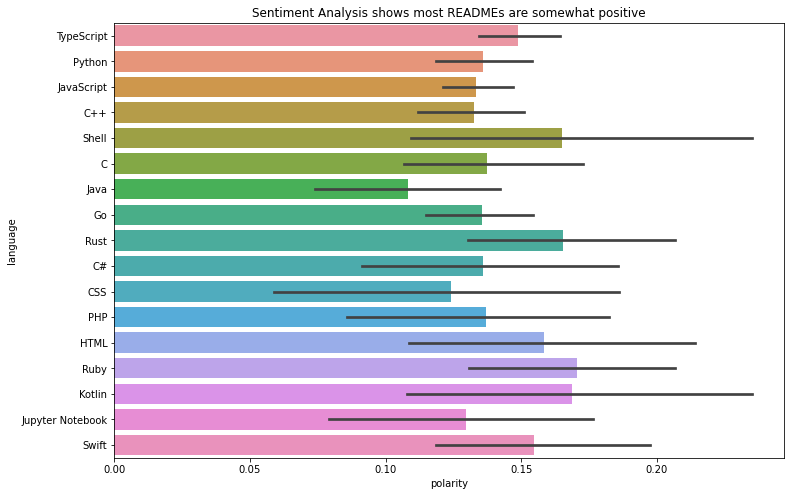

In [25]:
# Plotting Sentiment Analysis by language using a seaborn barplot
plt.figure(figsize=[12,8])
sns.barplot(data=df, y='language', x='polarity')
plt.title('Sentiment Analysis shows most READMEs are somewhat positive')
plt.show()

**Takeaways**:  It's nice to see that most READMEs have a positive spin.  However, there doesn't seem to be enough variance to suggest that sentiment analysis will be a very good feature to use in modeling.

# Modeling
---


### Important Note: During the process we worked with processing data in different ways. Please see josh's working notebook for how we prepared and modeled data differently than in our final notebook. 
Please use the below url to see Josh's notebook:
https://github.com/david-jarad-josh-saroj/project-github-readme-classification/blob/master/josh-workbook.ipynb

In [26]:
#Splitting the data to ensure not data leakage
train, validate, test = prepare.split_lang(df)

In [27]:
#Checking shapes
train.shape, validate.shape, test.shape

((548, 7), (137, 7), (172, 7))

### Baseline

In [28]:
#Creating a baseline
baseline = 149/548
baseline

0.2718978102189781

In [29]:

from sklearn.feature_extraction.text import TfidfVectorizer
#Vectorizing the text for model use
tfidf = TfidfVectorizer()
tfidf.fit(train.readme_contents)
# tfidf.fit(df.lemma)

xt = tfidf.transform(train.readme_contents).toarray()
xs = tfidf.transform(test.readme_contents).toarray()
xv = tfidf.transform(validate.readme_contents).toarray()

In [30]:
# Setting the Y variable
yt = train.language
ys = test.language
yv = validate.language

In [31]:
# Evaluating a baseline
from helpers.eval import BaselineModel
from sklearn.metrics import accuracy_score
baseline_model = BaselineModel(method='mode')
baseline_model.fit(xt, yt)

# Collecting accuracy metrics
bpt = baseline_model.predict(xt)
bps = baseline_model.predict(xs)
bpv = baseline_model.predict(xv)
bat = accuracy_score(yt, bpt)
bas = accuracy_score(ys, bps)
bav = accuracy_score(yv, bpv)

print(f"The accuracy to beat is {bat} in Train, {bav} in Validate, and {bas} in Test")

The accuracy to beat is 0.2718978102189781 in Train, 0.27007299270072993 in Validate, and 0.26744186046511625 in Test


In [34]:
# Encoding the type of failure to pass thru XGBoost
le = LabelEncoder()
yt_encoded = le.fit_transform(yt)
yv_encoded = le.transform(yv)
ys_encoded = le.transform(ys)

## Modeling on Uncleaned Data

We first use our XGB Classifier model and then SVM Model on uncleaned data. 

##### XGBoost Classifier

In [35]:

# fit model on training data and making classification report
model = XGBClassifier()
    
model.fit(xt, yt_encoded)

y_pred = model.predict(xt)

y_v_pred = model.predict(xv)

y_test_pred = model.predict(xs)
 
print(classification_report(yt_encoded, y_pred))




              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00        36
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        45
           7       1.00      1.00      1.00       149
           8       1.00      1.00      1.00         9
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00         9
          11       0.99      1.00      0.99        73
          12       1.00      1.00      1.00        11
          13       1.00      1.00      1.00        14
          14       1.00      1.00      1.00        14
          15       1.00      1.00      1.00        11
          16       1.00      1.00      1.00        70

    accuracy              

In [ ]:
#Checking how well it did on validate
print(classification_report(yv_encoded, y_v_pred))

              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.00      0.00      0.00         2
           2       0.44      0.44      0.44         9
           3       0.00      0.00      0.00         2
           4       0.53      0.75      0.62        12
           5       1.00      0.25      0.40         4
           6       0.64      0.82      0.72        11
           7       0.60      0.86      0.71        37
           8       0.00      0.00      0.00         2
           9       0.50      0.50      0.50         2
          10       1.00      1.00      1.00         2
          11       0.73      0.61      0.67        18
          12       0.67      0.67      0.67         3
          13       1.00      0.67      0.80         3
          14       0.67      0.50      0.57         4
          15       1.00      0.67      0.80         3
          16       0.60      0.33      0.43        18

    accuracy              

c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

##### XGBoost Random Forest Classifier

In [ ]:

# Fit model on training data and classification report
model2 = XGBRFClassifier()
    
model2.fit(xt, yt_encoded)

y_pred2 = model2.predict(xt)

y_v_pred2 = model2.predict(xv)
 
print(classification_report(yt_encoded, y_pred2))

              precision    recall  f1-score   support

           0       1.00      0.68      0.81        19
           1       0.70      0.88      0.78         8
           2       0.87      0.75      0.81        36
           3       1.00      0.25      0.40         8
           4       0.92      0.98      0.95        50
           5       1.00      0.36      0.53        14
           6       0.84      0.96      0.90        45
           7       0.85      0.95      0.90       149
           8       1.00      0.33      0.50         9
           9       0.83      0.62      0.71         8
          10       0.80      0.89      0.84         9
          11       0.79      0.95      0.86        73
          12       1.00      0.55      0.71        11
          13       1.00      1.00      1.00        14
          14       0.92      0.79      0.85        14
          15       0.83      0.91      0.87        11
          16       0.94      0.89      0.91        70

    accuracy              

In [ ]:
#Checking to see how well it did on validate
print(classification_report(yv_encoded, y_v_pred2))

              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.00      0.00      0.00         2
           2       0.50      0.11      0.18         9
           3       0.00      0.00      0.00         2
           4       0.56      0.75      0.64        12
           5       0.00      0.00      0.00         4
           6       0.64      0.82      0.72        11
           7       0.52      0.81      0.63        37
           8       0.00      0.00      0.00         2
           9       0.50      0.50      0.50         2
          10       0.67      1.00      0.80         2
          11       0.65      0.61      0.63        18
          12       0.00      0.00      0.00         3
          13       0.50      0.33      0.40         3
          14       1.00      0.25      0.40         4
          15       0.33      0.67      0.44         3
          16       0.55      0.33      0.41        18

    accuracy              

c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

##### SVM Linear Model

In [ ]:
#Setting SVM linear model to train and looking at the report
svm_model_linear = SVC(kernel = 'linear', C = 10).fit(xt, yt_encoded)
svm_predictions = svm_model_linear.predict(xv)
  
    # model accuracy for X_test  
accuracy = svm_model_linear.score(xv, yv_encoded)
  
    # creating a confusion matrix
#cm = confusion_matrix(y_validate, svm_predictions)

y_pred = svm_model_linear.predict(xt)

y_v_pred = svm_model_linear.predict(xv)

 
print(classification_report(yt_encoded, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       1.00      1.00      1.00         8
           2       1.00      0.97      0.99        36
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        45
           7       0.99      1.00      1.00       149
           8       1.00      1.00      1.00         9
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00         9
          11       0.99      1.00      0.99        73
          12       1.00      1.00      1.00        11
          13       1.00      1.00      1.00        14
          14       1.00      1.00      1.00        14
          15       1.00      1.00      1.00        11
          16       1.00      1.00      1.00        70

    accuracy              

In [ ]:
#Looking at the report on validate
print(classification_report(yv_encoded, y_v_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         2
           2       0.25      0.11      0.15         9
           3       0.00      0.00      0.00         2
           4       0.83      0.42      0.56        12
           5       0.00      0.00      0.00         4
           6       0.62      0.45      0.53        11
           7       0.35      0.89      0.50        37
           8       1.00      0.50      0.67         2
           9       1.00      0.50      0.67         2
          10       0.00      0.00      0.00         2
          11       0.77      0.56      0.65        18
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         3
          14       1.00      0.25      0.40         4
          15       1.00      0.33      0.50         3
          16       0.43      0.17      0.24        18

    accuracy              

c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

## Modeling on Lemmatized data
---
Running the cleaned and lemmatized data through our most promising model, XGBoost Classifier

In [ ]:
# Running the vectorization on the lemma version of 
tfidf_lem = TfidfVectorizer()
tfidf_lem.fit(train.lemm_readme)
# tfidf.fit(df.lemma)

xtl = tfidf_lem.transform(train.lemm_readme).toarray()
xsl = tfidf_lem.transform(test.lemm_readme).toarray()
xvl = tfidf_lem.transform(validate.lemm_readme).toarray()

In [5]:
# fit XGB model on training data
model = XGBClassifier()
    
model.fit(xtl, yt_encoded)

y_pred = model.predict(xtl)

y_v_pred = model.predict(xvl)

 
print(classification_report(yt_encoded, y_pred))

NameError: name 'XGBClassifier' is not defined

In [ ]:
print(classification_report(yv_encoded, y_v_pred))

              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.00      0.00      0.00         2
           2       0.33      0.33      0.33         9
           3       0.00      0.00      0.00         2
           4       0.53      0.67      0.59        12
           5       0.00      0.00      0.00         4
           6       0.80      0.73      0.76        11
           7       0.55      0.84      0.67        37
           8       0.00      0.00      0.00         2
           9       0.33      0.50      0.40         2
          10       1.00      1.00      1.00         2
          11       0.73      0.61      0.67        18
          12       1.00      0.33      0.50         3
          13       1.00      0.67      0.80         3
          14       0.33      0.25      0.29         4
          15       1.00      0.67      0.80         3
          16       0.62      0.44      0.52        18

    accuracy              

c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Our XGB model performs with 58% accuracy when fit on our cleaned and lemmatized training data

## Predict and Evaluate on Test 
---
Running the model on test

In [ ]:
# Displaying results of running XGB model on test sample
print(classification_report(ys_encoded, y_test_pred))

              precision    recall  f1-score   support

           0       0.67      0.33      0.44         6
           1       1.00      0.33      0.50         3
           2       0.18      0.18      0.18        11
           3       0.00      0.00      0.00         2
           4       0.62      0.62      0.62        16
           5       0.00      0.00      0.00         5
           6       0.75      0.86      0.80        14
           7       0.62      0.87      0.72        46
           8       0.50      0.33      0.40         3
           9       0.00      0.00      0.00         2
          10       1.00      0.33      0.50         3
          11       0.62      0.87      0.73        23
          12       0.67      0.50      0.57         4
          13       0.67      0.50      0.57         4
          14       0.40      0.50      0.44         4
          15       0.67      0.50      0.57         4
          16       0.33      0.09      0.14        22

    accuracy              

In [4]:
# Finding how much my model beat baseline by and printing the result
model_percent = abs(((0.58)-(0.27)) / (0.27))

print("The model beat baseline by: "+"{:.2%}".format(model_percent))

The model beat baseline by: 114.81%


We expect this model to perform with 58% accuracy in the future on data it has not seen, given no major changes in our data source.

# Conclusion

### Summary

In seeking to predict programming language for GitHub repositories, we have explored our data thoroughly. \
We observed word clouds, word frequencies, and ran sentiment analyses in order to best determine any additional feature engineering that would improve our model. Although we were not able to identify any additional significant features to engineer from this exploration, we were able to identify problem areas and eliminate a host of stopwords which resulted in improved modeling.

Additionally, we have created and tested 12 different models on both uncleaned and cleaned and lemmatized data. Our 3 best performing models are:

1. Neural Network (not explicitly shown in this final notebook)
2. SVM Linear
3. XGBoost Classifier

In short, we found that our XGBoost Classifier model performed best on our uncleaned data, resulting in 58% accuracy on our test data. \
This performance beats our baseline by 115%.


### Next Steps

Despite the overall effectiveness of our best-performing model, there is always room for improvement and optimization.
If given more time to pursue better results, we could perform further investigation within exploration by:

1. Estimating each readme's school reading level. Not only would this be interesting as an anecdote, if proven useful, it could be imputed as a new feature to boost the accuracy of our model.

2. Handling ReadMes in a foreign language in a more succinct way. This could be handled more effectively by using a translator to convert all ReadMes into English for potentially better modeling accuracy. 



